# Early detection of Alzheimer's disease using blood gene expression data
## Design Project
by J. Hariharan and Dr. R. Jothi

## Packages

In [3]:
import pandas as pd
import numpy as np
import GEOparse
import os
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
import csv
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

## Pre-Processing

### Parsing GSE63060 and GSE63061 dataset

In [24]:
dataset_directory = "../DataSets/"
parsed_data_file_suffix = "_parsed_data.csv"

In [30]:
gses = {}

gses["GSE63060"] = GEOparse.get_GEO(filepath="../DataSets/GSE63060_family.soft.gz")
gses["GSE63061"] = GEOparse.get_GEO(filepath="../DataSets/GSE63061_family.soft.gz")

len(gses)

02-Mar-2023 18:34:28 INFO GEOparse - Parsing ../DataSets/GSE63060_family.soft.gz: 
02-Mar-2023 18:34:28 DEBUG GEOparse - DATABASE: GeoMiame
02-Mar-2023 18:34:28 DEBUG GEOparse - SERIES: GSE63060
02-Mar-2023 18:34:28 DEBUG GEOparse - PLATFORM: GPL6947
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539080
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539081
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539082
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539083
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539084
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539085
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539086
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539087
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539088
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539089
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539090
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539091
02-Mar-2023 18:34:29 DEBUG GEOparse - SAMPLE: GSM1539092
02-Mar-2

2

In [31]:
# 1. Finding Gene symbols for the ID_REF values
# 2. Group the rows based on Gene Symbol values
# 3. replace the groups with a single row with Gene Symbol of the group and the Median of the gene expression value

for datasetName in gses:
    gse = gses[datasetName]
    gpl_lookup = []

    for gpl_name, gpl in gse.gpls.items():
        gpl_lookup = gpl.table.filter(["ID", "ILMN_Gene"]).set_index("ID")[
            "ILMN_Gene"].to_dict()

    column_names = ["sample_id", "status", "ethinicity",
                    "age", "gender", "included_in_case_study", "tissue"]
    values = []
    for gsm_name, gsm in gse.gsms.items():
        row = {}
        row[column_names[0]] = gsm_name

        for characteristic in gsm.metadata["characteristics_ch1"]:
            chsplit = characteristic.split(": ")
            row[chsplit[0]] = chsplit[1]

        tempdf = gsm.table.copy(deep=True)
        tempdf["ID_REF"] = tempdf["ID_REF"].apply(
            lambda id_ref: gpl_lookup[id_ref])
        tempdf = tempdf["VALUE"].groupby(tempdf["ID_REF"])
        for key, group in tempdf:
            row[key] = group.median()

        values.append(row)

    dataset = pd.DataFrame.from_dict(values)
    dataset.to_csv(dataset_directory + datasetName + parsed_data_file_suffix, index=False)

### Integrating the parsed datasets

In [168]:
datasets = []
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# Loading the parsed data
file_Id = 0
for file in os.listdir(dataset_directory):
    if file.endswith("_parsed_data.csv"):
        file_path = os.path.join(dataset_directory, file)
        dataset = pd.read_csv(file_path, index_col="sample_id")
        x_scaled_values = min_max_scaler.fit_transform(dataset.iloc[:, 6:].values)
        dataset.iloc[:, 6:] = x_scaled_values        
        datasets.append(dataset)


In [169]:
# extract only common columns
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

common_columns = datasets[0]
for i in range(1, len(datasets)):
    common_columns = intersection(common_columns, datasets[i])

print("No of Common Columns :", end=" ")
print(len(common_columns))

for i in range(len(datasets)):
    datasets[i] = datasets[i][common_columns]
    print(datasets[i].shape)

master_dataset = pd.concat(datasets)

print(master_dataset.shape)

# Save master dataset
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

No of Common Columns : 12459
(388, 12459)
(329, 12459)
(431, 12459)
(1148, 12459)


,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Min-Max Normalisation of the Master Data

In [170]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_scaled_values = min_max_scaler.fit_transform(master_dataset.iloc[:, 6:].values)
master_dataset.iloc[:, 6:] = x_scaled_values
master_dataset.to_csv(dataset_directory+"master_dataset.csv")
master_dataset.head()

,status,age,gender,included in case -control study,tissue,A1BG,A1CF,A4GALT,A4GNT,AAAS,...,ZW10,ZWILCH,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539409,MCI,57,Female,yes,blood,0.842142,0.141849,0.270089,0.414582,0.366943,...,0.491837,0.362170,0.242994,0.324213,0.382473,0.219812,0.506150,0.564975,0.783020,0.280390
GSM1539410,MCI,59,Female,yes,blood,0.082720,0.217729,0.219648,0.098985,0.546756,...,0.620090,0.154047,0.268210,0.432774,0.485216,0.338584,0.657337,0.897605,0.828350,0.198357
GSM1539411,MCI,63,Female,yes,blood,0.342776,0.419005,0.223242,0.485604,0.707504,...,0.604173,0.602999,0.118003,0.391065,0.495688,0.369816,0.433200,0.567302,0.616342,0.417443
GSM1539412,MCI,65,Female,yes,blood,0.844631,0.278016,0.351760,0.171538,0.396991,...,0.161829,0.081752,0.268977,0.215652,0.411997,0.218022,0.672268,0.741393,0.573071,0.127701
GSM1539413,MCI,66,Female,yes,blood,0.354327,0.100254,0.039218,0.493919,0.163816,...,0.163634,0.318442,0.560799,0.102833,0.306091,0.164445,0.833463,0.565744,0.366652,0.397025


### Loading Processed Dataset

In [165]:
### Loading Processed data
master_dataset = pd.read_csv("../DataSets/master_dataset.csv", index_col="sample_id")
master_dataset.shape


(1148, 12459)

In [166]:
master_dataset = master_dataset[(master_dataset["status"] == "AD") | (master_dataset["status"] == "CTL")]
AD_dataset = master_dataset[master_dataset["status"] == "AD"]
CTL_dataset = master_dataset[master_dataset["status"] == "CTL"]
no_of_ad_samples = AD_dataset.shape[0]
no_of_ctl_samples = CTL_dataset.shape[0]
min_no_samples = min(no_of_ad_samples, no_of_ctl_samples)
AD_dataset = AD_dataset.sample(min_no_samples, random_state=2206)
CTL_dataset = CTL_dataset.sample(min_no_samples, random_state=22)
master_dataset = pd.concat([AD_dataset, CTL_dataset])

master_dataset["status"].value_counts()

AD     238
CTL    238
Name: status, dtype: int64

### 80-20 Test and Train Split

In [167]:
X = master_dataset.iloc[:, 5:]
Y = master_dataset["status"].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=2222)

In [168]:

print("AD and CTL samples in Training set : ", end="")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print("AD and CTL samples in Testing set : ", end="")
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

AD and CTL samples in Training set : {'AD': 190, 'CTL': 190}
AD and CTL samples in Testing set : {'AD': 48, 'CTL': 48}


## Feature Selection

### Chi-square Feature Selection

In [34]:
def ChiSquare(X, Y, no_of_features_to_select):
    gene_to_select = []

    chi2 = feature_selection.SelectKBest(feature_selection.chi2, k=no_of_features_to_select)
    chi2.fit_transform(X, Y)
    chi2_support = chi2.get_support()

    for i in range(len(chi2_support)):
        if(chi2_support[i] == True):
            gene_to_select.append(X.columns[i])

    return gene_to_select

#### Method to find the optiminum Number of Genes to select

In [ ]:
chi_square_results = []
no_feature_to_select = 14

while no_feature_to_select <= len(X.columns):
    result = {}
    genes_to_select = ChiSquare(x_train, y_train, no_feature_to_select)
    x_train_with_subset_features = x_train[genes_to_select]
    x_test_with_subset_features = x_test[genes_to_select]

    svm_model = SVC(kernel="linear")
    svm_model.fit(x_train_with_subset_features, y_train)

    train_score = svm_model.score(x_train_with_subset_features, y_train)
    test_score = svm_model.score(x_test_with_subset_features, y_test)

    result["no_of_features"] = no_feature_to_select
    result["train_score"] = train_score
    result["test_score"] = test_score

    chi_square_results.append(result)
    #print(no_feature_to_select)
    no_feature_to_select += 100

chi_square_results = pd.DataFrame.from_dict(chi_square_results)

In [36]:
fig = px.line(chi_square_results, x="no_of_features", y=["train_score", "test_score"])
fig.show()

Optimum no. of genes is found to be top **10814**

In [38]:
chi_square_optimum_genes = ChiSquare(x_train, y_train, 10814)
x_train_with_subset_features = x_train[chi_square_optimum_genes]
x_test_with_subset_features = x_test[chi_square_optimum_genes]

svm_model = SVC(kernel="linear")
svm_model.fit(x_train_with_subset_features, y_train)

train_score = svm_model.score(x_train_with_subset_features, y_train)
test_score = svm_model.score(x_test_with_subset_features, y_test)

print("Training Accuracy : ", end="")
print(train_score)
print("Testing Accuracy : ", end="")
print(test_score)

Training Accuracy : 1.0
Testing Accuracy : 0.9375


#### Saving the 10814 genes for futher analysis

In [44]:
with open('Chi_Square_Selected_Features.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(chi_square_optimum_genes)

### ANOVA Feature Selection

In [169]:
def ANOVA(X, Y, no_feature_to_select):
    anova = SelectKBest(f_classif, k = no_feature_to_select)
    anova.fit(X, Y)

    return anova

#### Method to find Optimum Number of genes to select

In [145]:
anova_results = []
no_feature_to_select = 14

while no_feature_to_select <= len(X.columns) - 6000:
    result = {}
    anova_model = ANOVA(x_train, y_train, no_feature_to_select)
    x_train_with_subset_features = anova_model.transform(x_train)
    x_test_with_subset_features = anova_model.transform(x_test)

    svm_model = SVC(kernel="linear")
    svm_model.fit(x_train_with_subset_features, y_train)

    train_score = svm_model.score(x_train_with_subset_features, y_train)
    test_score = svm_model.score(x_test_with_subset_features, y_test)

    result["no_of_features"] = no_feature_to_select
    result["train_score"] = train_score
    result["test_score"] = test_score

    anova_results.append(result)
    print(no_feature_to_select)
    no_feature_to_select += 100

anova_results = pd.DataFrame.from_dict(anova_results)

14
114
214
314
414
514
614
714
814
914
1014
1114
1214
1314
1414
1514
1614
1714
1814
1914
2014
2114
2214
2314
2414
2514
2614
2714
2814
2914
3014
3114
3214
3314
3414
3514
3614
3714
3814
3914
4014
4114
4214
4314
4414
4514
4614
4714
4814
4914
5014
5114
5214
5314
5414
5514
5614
5714
5814
5914
6014
6114
6214
6314
6414


In [146]:
fig = px.line(anova_results, x="no_of_features", y=["train_score", "test_score"])
fig.show()

Optimum no. of genes is found to be top **514**

In [170]:
anova_model = ANOVA(x_train, y_train, 514)
x_train_with_subset_features = anova_model.transform(x_train)
x_test_with_subset_features = anova_model.transform(x_test)

svm_model = SVC(kernel="linear")
svm_model.fit(x_train_with_subset_features, y_train)

train_score = svm_model.score(x_train_with_subset_features, y_train)
test_score = svm_model.score(x_test_with_subset_features, y_test)

print("Test Score : ", end="")
print(test_score)

Test Score : 0.9166666666666666


#### Saving the 514 genes for futher analysis

In [171]:
anova_scores = sorted(list(zip(anova_model.scores_, x_train.columns)), reverse=True)
anova_optimum_genes = []

for entry in anova_scores[:514]:
    anova_optimum_genes.append(entry[1])

with open('./FeatureSubsets/ANOVA_Selected_Features.csv', 'w') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(anova_optimum_genes)

#### Saving dataset with selected genes using ANOVA in sperate CSV for later use

In [172]:
columns_to_select = pd.read_csv("./FeatureSubsets//ANOVA_Selected_Features.csv", header=None).to_numpy()
columns_to_select = np.append(columns_to_select, "status")

master_dataset_with_anova_optimum_genes = master_dataset[columns_to_select]
master_dataset_with_anova_optimum_genes.to_csv("../DataSets/master_dataset_anova.csv")


In [173]:
master_dataset_with_anova_optimum_genes

,MRPL33,RPL36AL,RPS27A,FCGR3A,TXNDC5,BTN3A1,CSF2RB,COX17,ROR1,CYB5B,...,STAG2,KRTAP9-8,ATR,H2AFZ,ROBO3,FCGR3B,CGB1,DCUN1D1,ZIC2,status
sample_id,,,,,,,,,,,,,,,,,,,,,
GSM1539266,0.227666,0.472327,0.360539,0.239006,0.198319,0.479612,0.238694,0.330269,0.476801,0.846306,...,0.387971,0.321020,0.319218,0.387225,0.433365,0.576436,0.303657,0.368872,0.201156,AD
GSM1539240,0.226078,0.487462,0.366249,0.380028,0.177006,0.848257,0.625749,0.194806,0.564088,0.547941,...,0.087999,0.171554,0.456206,0.293272,0.329105,0.822580,0.131990,0.285651,0.297134,AD
023_S_0217,0.385587,0.658960,0.643337,0.974273,0.790619,0.847420,0.186108,0.402737,0.115131,0.174613,...,0.447810,0.672340,0.413162,0.699580,0.286750,0.935110,0.640496,0.539716,0.000000,AD
082_S_4208,0.173391,0.227911,0.426174,0.999612,0.783827,0.814226,0.145281,0.447532,0.062562,0.258824,...,0.394468,0.400000,0.428349,0.468487,0.495164,0.924007,0.461157,0.695745,0.457050,AD
007_S_4620,0.186634,0.360033,0.602589,0.958242,0.773745,0.814784,0.111877,0.236416,0.066760,0.252219,...,0.641422,0.377660,0.485202,0.517857,0.392166,0.839872,0.183471,0.595981,0.431118,AD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM1539671,0.779042,0.898347,0.861934,0.317949,0.444673,0.132069,0.465774,0.887267,0.403040,0.639239,...,0.374446,0.301452,0.452665,0.855759,0.146979,0.563792,0.323087,0.378860,0.287845,CTL
GSM1539177,0.591625,0.741628,0.707659,0.055940,0.272802,0.233071,0.282464,0.499789,0.482780,0.785822,...,0.346247,0.319204,0.639717,0.647207,0.308125,0.584555,0.213971,0.285878,0.229123,CTL
GSM1539483,0.504988,0.551617,0.782030,0.575554,0.180015,0.348713,0.513625,0.473800,0.245348,0.563429,...,0.054398,0.196508,0.510288,0.484448,0.564503,0.570947,0.555673,0.448059,0.183916,CTL


## Tabular Data Augmentation

## Classification Techniques

In [237]:
dataset = pd.read_csv("../DataSets/master_dataset_anova.csv", index_col="sample_id")
X = dataset.iloc[:, :-1]
Y = dataset["status"].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=2222)

### Ensemble Methods

In [239]:
model = RandomForestClassifier(n_estimators=100)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(y_train, y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(y_test, y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8854166666666666


In [240]:
model = AdaBoostClassifier(n_estimators=100)

model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(y_train, y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(y_test, y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8645833333333334


In [309]:
vanilla_X = master_dataset.iloc[:, 6:].values
vanilla_Y = master_dataset["status"].values

vanilla_x_train, vanilla_x_test, vanilla_y_train, vanilla_y_test = train_test_split(vanilla_X, vanilla_Y, test_size=0.30, shuffle=True)

In [310]:
model = AdaBoostClassifier(n_estimators=500)

model.fit(vanilla_x_train, vanilla_y_train)

vanilla_y_train_pred = model.predict(vanilla_x_train)
vanilla_y_test_pred = model.predict(vanilla_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(vanilla_y_train, vanilla_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(vanilla_y_test, vanilla_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.9020979020979021


In [296]:
pca_model = PCA(n_components=30)
pca_model.fit(master_dataset.iloc[:, 6:])
pca_X = pca_model.transform(master_dataset.iloc[:, 6:])
pca_Y = master_dataset["status"].values

In [297]:
pca_x_train, pca_x_test, pca_y_train, pca_y_test = train_test_split(pca_X, pca_Y, test_size=0.10, shuffle=True)

In [299]:
model = RandomForestClassifier(n_estimators=100)

model.fit(pca_x_train, pca_y_train)

pca_y_train_pred = model.predict(pca_x_train)
pca_y_test_pred = model.predict(pca_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_train, pca_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_test, pca_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.75


In [314]:
model = AdaBoostClassifier(n_estimators=100)

model.fit(pca_x_train, pca_y_train)

pca_y_train_pred = model.predict(pca_x_train)
pca_y_test_pred = model.predict(pca_x_test)

print("Training Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_train, pca_y_train_pred))
print("Test Accuracy : ", end="")
print(metrics.accuracy_score(pca_y_test, pca_y_test_pred))

Training Accuracy : 1.0
Test Accuracy : 0.8333333333333334


### Deep Learning

In [243]:
#Label encoding
def LabelEncoding(Y): 
    le = preprocessing.LabelEncoder()
    le.fit(Y)
    Y = le.transform(Y)
    return Y

y_test = LabelEncoding(y_test)
y_train = LabelEncoding(y_train)

y_test = tf.one_hot(y_test, depth=1)
y_train = tf.one_hot(y_train, depth=1)

In [255]:
dnn_model = tf.keras.models.Sequential()
dnn_model.add(tf.keras.layers.Dense(6, activation="relu", input_shape=(514,)))
dnn_model.add(tf.keras.layers.Dense(5, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(5, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(5, activation="relu"))
dnn_model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

dnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
dnn_results = dnn_model.fit(x_train, y_train, epochs=100, batch_size=5, validation_data=(x_test, y_test))

Epoch 1/100
 1/76 [..............................] - ETA: 26s - loss: 0.6919 - accuracy: 0.6000

2023-05-15 19:17:09.146603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.6342

2023-05-15 19:17:09.907789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


76/76 [==============================] - 1s 11ms/step - loss: 0.6777 - accuracy: 0.6342 - val_loss: 0.6697 - val_accuracy: 0.5833
Epoch 2/100
76/76 [==============================] - 1s 8ms/step - loss: 0.6614 - accuracy: 0.6553 - val_loss: 0.6525 - val_accuracy: 0.6771
Epoch 3/100
76/76 [==============================] - 1s 8ms/step - loss: 0.6445 - accuracy: 0.6842 - val_loss: 0.6349 - val_accuracy: 0.6771
Epoch 4/100
76/76 [==============================] - 1s 8ms/step - loss: 0.6277 - accuracy: 0.6763 - val_loss: 0.6153 - val_accuracy: 0.7083
Epoch 5/100
76/76 [==============================] - 1s 8ms/step - loss: 0.6109 - accuracy: 0.7026 - val_loss: 0.5976 - val_accuracy: 0.7083
Epoch 6/100
76/76 [==============================] - 1s 8ms/step - loss: 0.5915 - accuracy: 0.6974 - val_loss: 0.5829 - val_accuracy: 0.6979
Epoch 7/100
76/76 [==============================] - 1s 8ms/step - loss: 0.5761 - accuracy: 0.7026 - val_loss: 0.5709 - val_accuracy: 0.6979
Epoch 8/100
76/76 [=====

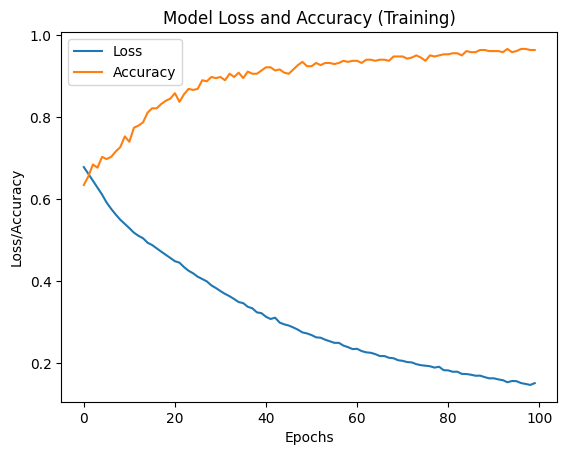

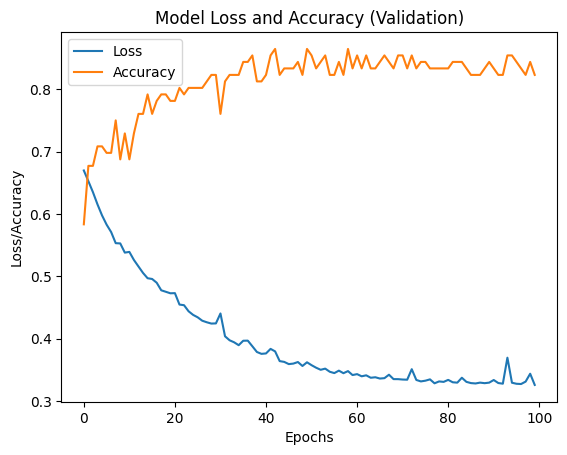

In [256]:
#Plotting the training results
import matplotlib.pyplot as plt
plt.plot(dnn_results.history["loss"])
plt.plot(dnn_results.history["accuracy"])
plt.title("Model Loss and Accuracy (Training)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Loss", "Accuracy"])
plt.show()

#Plotting the testing results
import matplotlib.pyplot as plt
plt.plot(dnn_results.history["val_loss"])
plt.plot(dnn_results.history["val_accuracy"])
plt.title("Model Loss and Accuracy (Validation)")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(["Loss", "Accuracy"])
plt.show()